<a href="https://colab.research.google.com/github/Papaxristos/Agriculture/blob/main/Agriculture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade scikit-learn


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from scipy.stats import zscore
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Connect to Google Drive
drive.mount('/content/drive')

# Load the data
file_path = '....../Agriculture/wheat-production.csv' #CONNECT YOUR PATH
data = pd.read_csv(file_path)

# Display the first 5 rows of the data
data.head()


Mounted at /content/drive


,Entity,Code,Year,Wheat | 00000015 || Production | 005510 || tonnes
0,Afghanistan,AFG,1961,2279000.0
1,Afghanistan,AFG,1962,2279000.0
2,Afghanistan,AFG,1963,1947000.0
3,Afghanistan,AFG,1964,2230000.0
4,Afghanistan,AFG,1965,2282000.0


In [3]:
# Load the data
file_path = '....../wheat-production.csv' #CONNECT YOUR PATH
data = pd.read_csv(file_path)

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Encode all categorical columns
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

# Display the result
print("Encoded Data:")
print(data)


Encoded Data:
      Entity  Code  Year  Wheat | 00000015 || Production | 005510 || tonnes
0          0     0  1961                                          2279000.0
1          0     0  1962                                          2279000.0
2          0     0  1963                                          1947000.0
3          0     0  1964                                          2230000.0
4          0     0  1965                                          2282000.0
...      ...   ...   ...                                                ...
9623     174   132  2018                                            45000.0
9624     174   132  2019                                            94685.0
9625     174   132  2020                                           212530.0
9626     174   132  2021                                           337212.0
9627     174   132  2022                                           200000.0

[9628 rows x 4 columns]


Basic Statistics:
            Entity         Code         Year  \
count  9628.000000  9628.000000  9628.000000   
mean     86.830183    83.087869  1992.663378   
std      50.350067    44.582951    17.888654   
min       0.000000     0.000000  1961.000000   
25%      43.000000    43.750000  1977.000000   
50%      87.000000    88.000000  1994.000000   
75%     128.000000   133.000000  2008.000000   
max     174.000000   133.000000  2022.000000   

       Wheat | 00000015 || Production | 005510 || tonnes  
count                                       9.628000e+03  
mean                                        2.240747e+07  
std                                         6.308441e+07  
min                                         0.000000e+00  
25%                                         3.300900e+04  
50%                                         9.901500e+05  
75%                                         1.141257e+07  
max                                         8.084416e+08  

Missing data per 

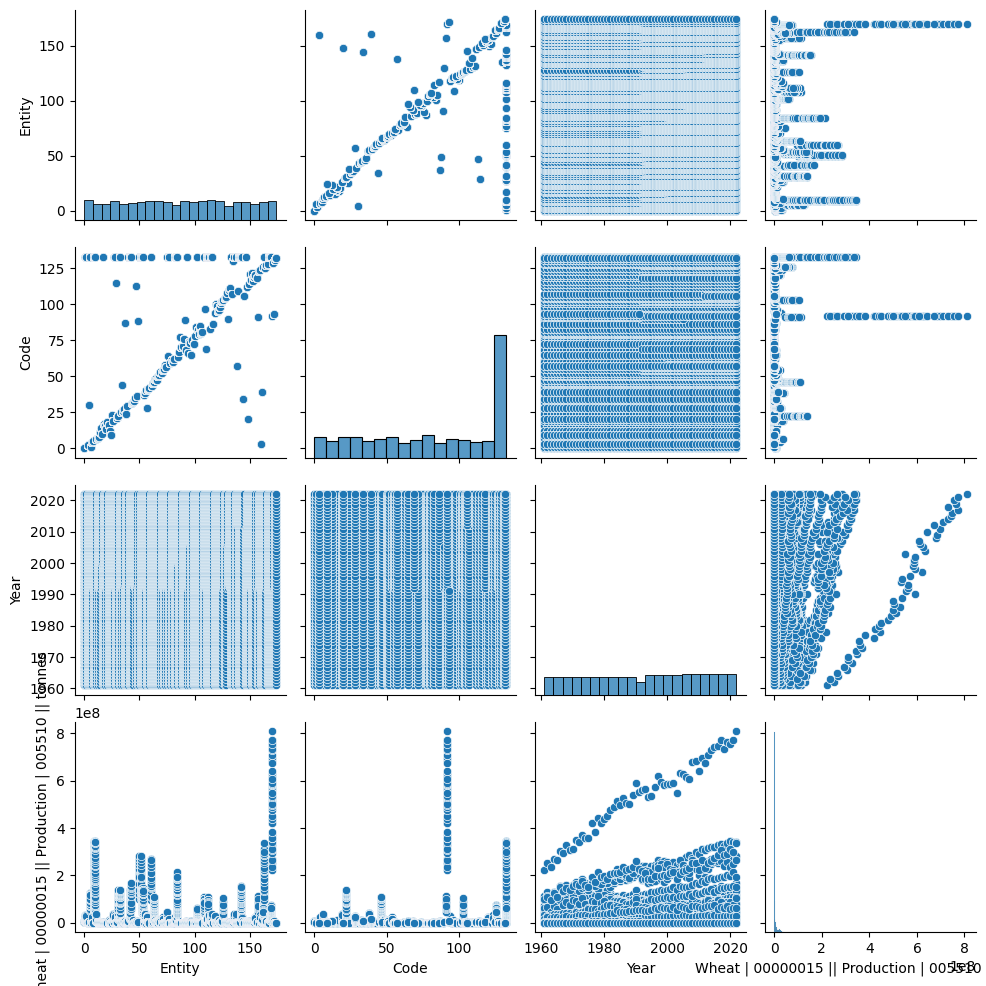

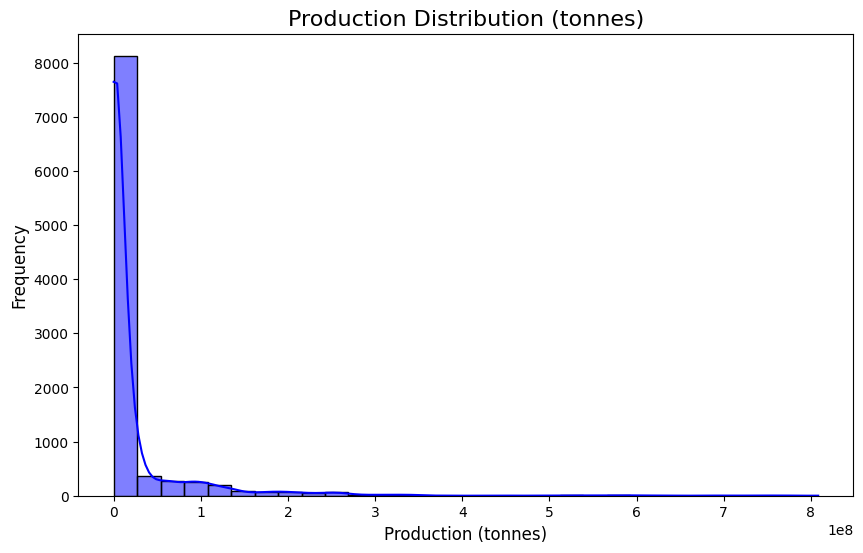

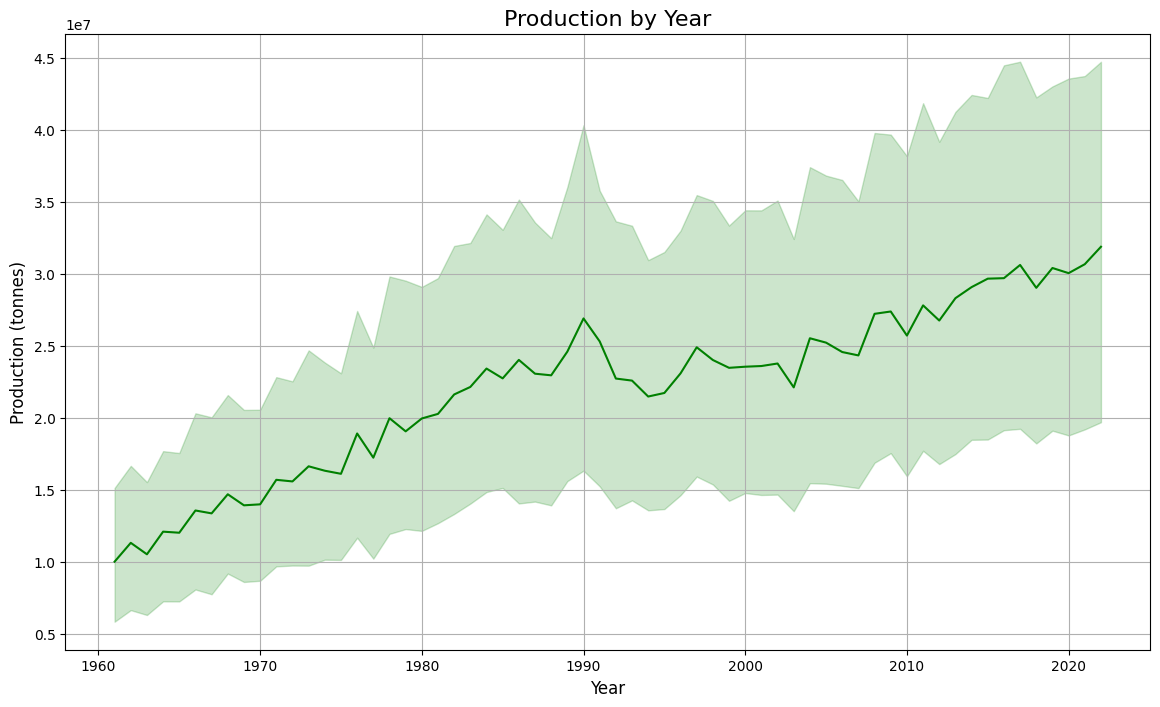

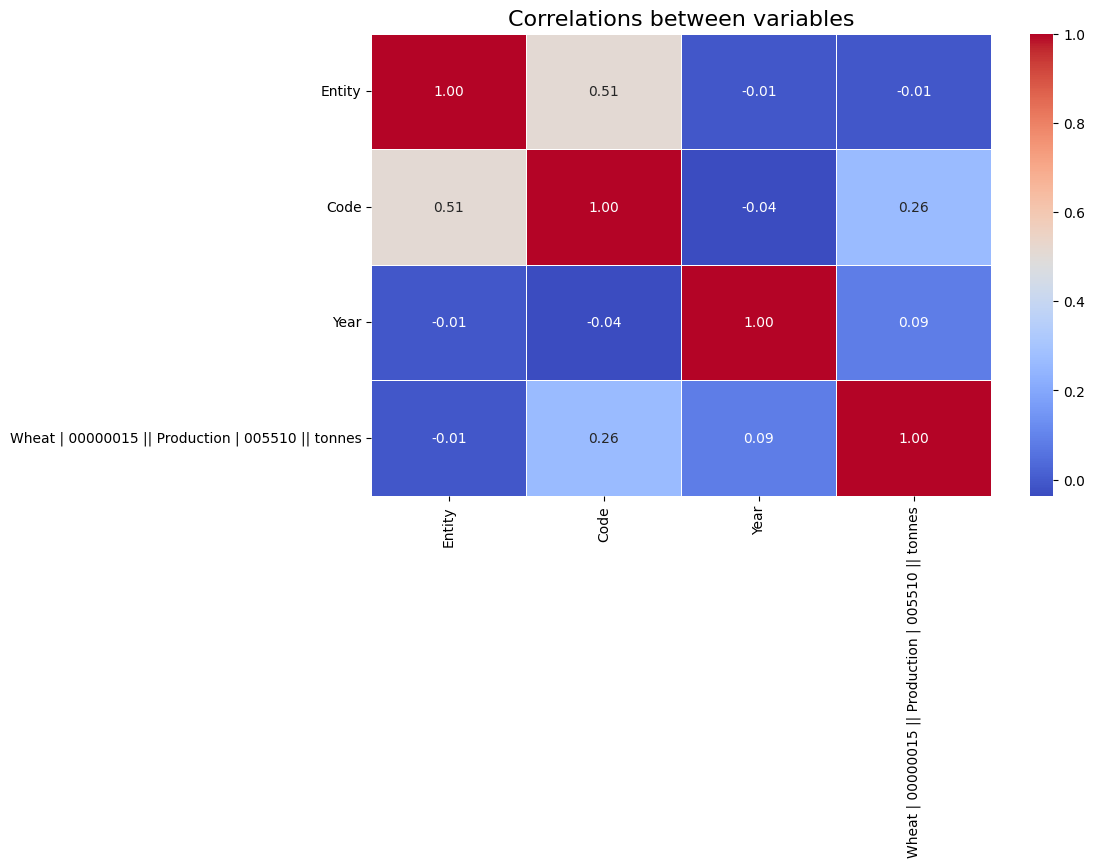

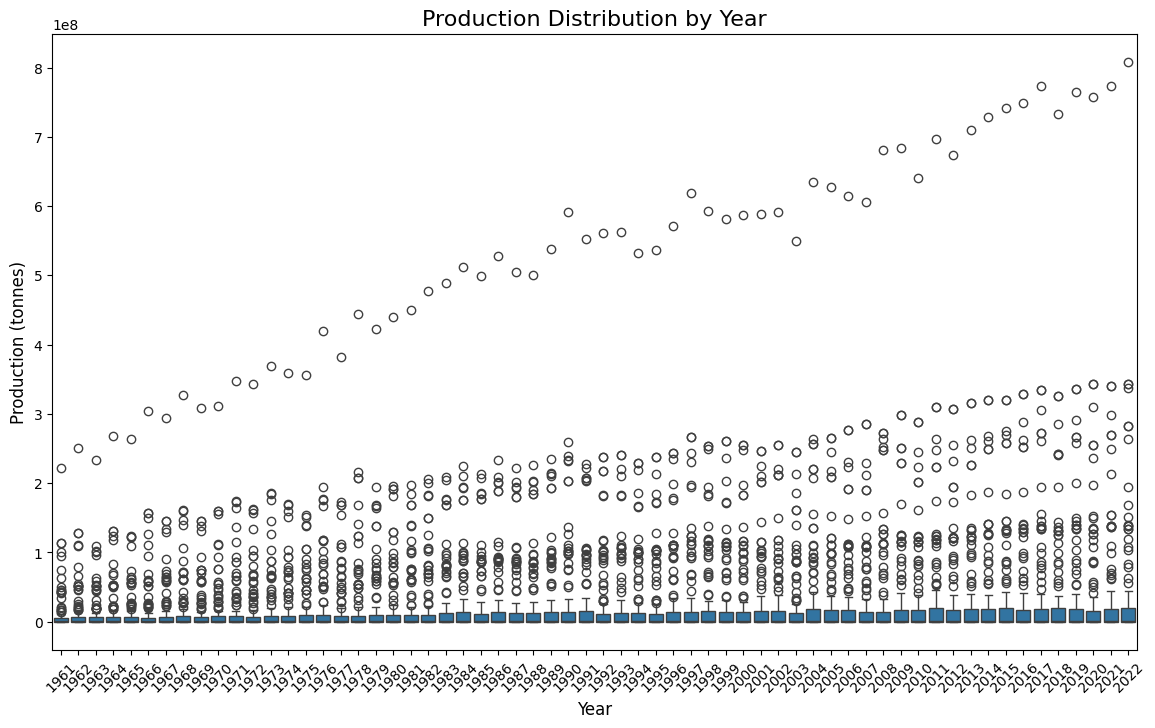

In [5]:
# Basic statistics analysis
print("Basic Statistics:")
print(data.describe())

# Check for missing data
print("\nMissing data per column:")
print(data.isnull().sum())

# Pairplot for quick exploration of relationships
sns.pairplot(data)
plt.show()

# Distribution of production
plt.figure(figsize=(10, 6))
sns.histplot(data['Wheat | 00000015 || Production | 005510 || tonnes'], kde=True, bins=30, color='blue')
plt.title('Production Distribution (tonnes)', fontsize=16)
plt.xlabel('Production (tonnes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Production over the years (Time trends)
plt.figure(figsize=(14, 8))
sns.lineplot(data=data, x='Year', y='Wheat | 00000015 || Production | 005510 || tonnes', color='green')
plt.title('Production by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Production (tonnes)', fontsize=12)
plt.grid()
plt.show()

# Correlations between variables
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlations between variables', fontsize=16)
plt.show()

# Boxplots for production by year
plt.figure(figsize=(14, 8))
sns.boxplot(x='Year', y='Wheat | 00000015 || Production | 005510 || tonnes', data=data)
plt.title('Production Distribution by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Production (tonnes)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [6]:
# Replace NaN values only in numerical columns with the mean of each column
data[data.select_dtypes(include=[np.number]).columns] = data.select_dtypes(include=[np.number]).fillna(data.mean())

# Calculate the Z-score for each numerical column
z_scores = np.abs(zscore(data.select_dtypes(include=[np.number])))

# Set the threshold for defining outliers
threshold = 3
outliers = (z_scores > threshold).all(axis=1)

# Remove the outliers
cleaned_data = data[~outliers]

# Display the cleaned data
print("Cleaned Data (without outliers and NaN):")
print(cleaned_data)

# Create a file with the cleaned data
cleaned_data.to_csv('....../cleaned_wheat_data.csv', index=False) #CONNECT YOUR PATH


Cleaned Data (without outliers and NaN):
      Entity  Code  Year  Wheat | 00000015 || Production | 005510 || tonnes
0          0     0  1961                                          2279000.0
1          0     0  1962                                          2279000.0
2          0     0  1963                                          1947000.0
3          0     0  1964                                          2230000.0
4          0     0  1965                                          2282000.0
...      ...   ...   ...                                                ...
9623     174   132  2018                                            45000.0
9624     174   132  2019                                            94685.0
9625     174   132  2020                                           212530.0
9626     174   132  2021                                           337212.0
9627     174   132  2022                                           200000.0

[9628 rows x 4 columns]


Initial Model - MSE: 365248843142609.19, R²: 0.91
Optimized Model - MSE: 355093987431495.00, R²: 0.91


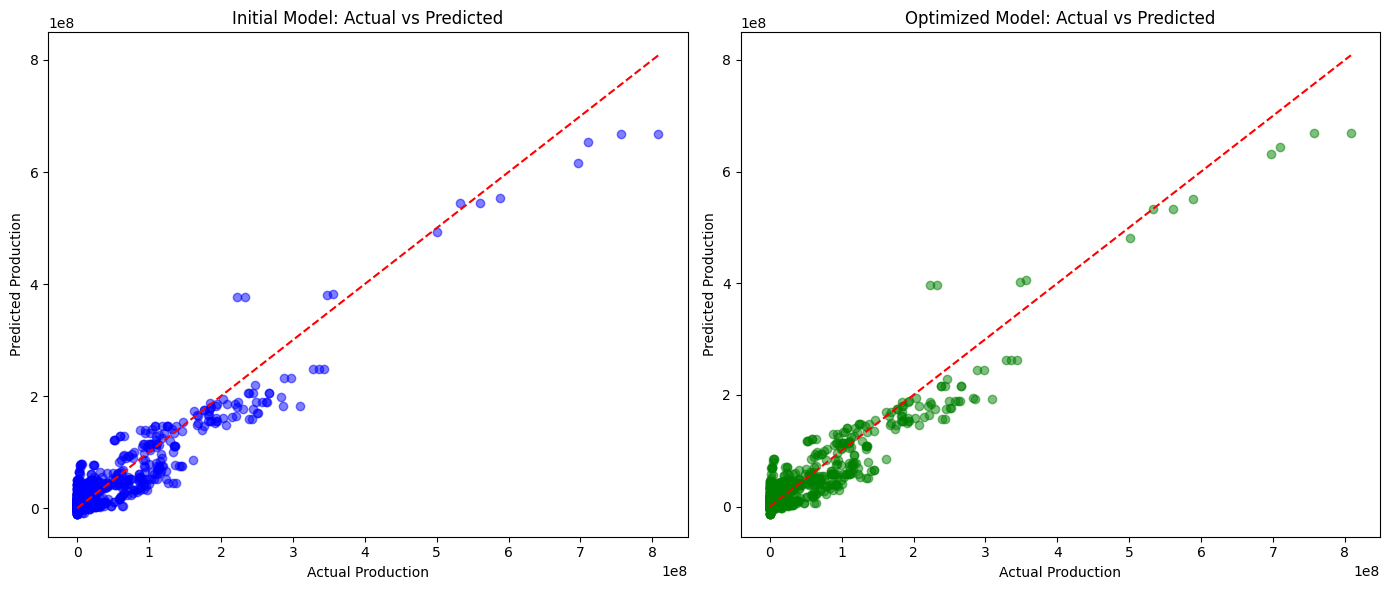

In [7]:
# Load the data from the file
file_path = '....../cleaned_wheat_data.csv' #CONNECT YOUR PATH
data = pd.read_csv(file_path)

# Clean the name of the column containing wheat production
data.rename(columns={
    'Wheat | 00000015 || Production | 005510 || tonnes': 'Production'
}, inplace=True)

# Split into X and Y
X = data.drop(columns=['Production'])  # The independent variables
Y = data['Production']  # The dependent variable

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create and train the initial model
gradient_boosting = GradientBoostingRegressor(random_state=42)
gradient_boosting.fit(X_train, Y_train)

# Create and train the optimized model
best_model = GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.05)
best_model.fit(X_train, Y_train)

# Predictions for the initial and optimized models
Y_pred = gradient_boosting.predict(X_test)
Y_pred_best = best_model.predict(X_test)

# Calculate MSE and R²
mse_initial = mean_squared_error(Y_test, Y_pred)
r2_initial = r2_score(Y_test, Y_pred)
mse_optimized = mean_squared_error(Y_test, Y_pred_best)
r2_optimized = r2_score(Y_test, Y_pred_best)

# Print the results
print(f'Initial Model - MSE: {mse_initial:.2f}, R²: {r2_initial:.2f}')
print(f'Optimized Model - MSE: {mse_optimized:.2f}, R²: {r2_optimized:.2f}')

# Create plots to compare actual vs predicted values

plt.figure(figsize=(14, 6))

# Plot for the initial model
plt.subplot(1, 2, 1)
plt.scatter(Y_test, Y_pred, color='blue', alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--')  # Diagonal line
plt.title('Initial Model: Actual vs Predicted')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')

# Plot for the optimized model
plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_pred_best, color='green', alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--')  # Diagonal line
plt.title('Optimized Model: Actual vs Predicted')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')

plt.tight_layout()
plt.show()


In [9]:
# Save the results to Drive
results = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})
results.to_csv('...../wheat_predictions.csv', index=False) #CONNECT YOUR PATH

